<a href="https://colab.research.google.com/github/KotaHonda/test_CNN/blob/master/CNN_0722.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import os
import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Input, Activation, Dropout, Flatten, Dense
from keras.layers import Conv2D, AveragePooling2D, MaxPooling2D
from sklearn.metrics import confusion_matrix
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras import optimizers
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
epochs = 20
batch_size = 128

画像のダウンロード

In [ ]:
(X_train_image, Y_train_label), (X_test_image, Y_test_label) = cifar10.load_data()
print(X_train_image.shape, Y_train_label.shape, X_test_image.shape, Y_test_label.shape)

ラベル設定

In [29]:
label_list = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

In [ ]:
Y_train_label

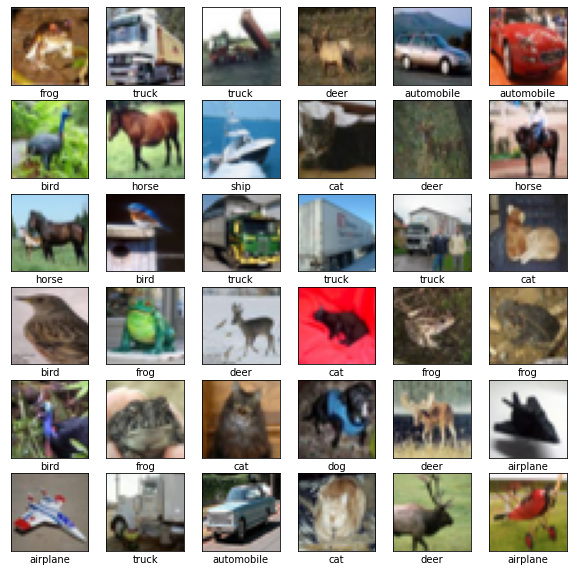

In [33]:
plt.figure(figsize=(10,10))
for i in range(36):
    plt.subplot(6, 6, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train_image[i])
    plt.xlabel(label_list[Y_train_label[i][0]])

値域の確認と正規化

In [34]:
print(np.min(X_train_image), np.max(X_train_image), np.min(X_test_image), np.max(X_test_image))

X_train = X_train_image.astype('float32')
X_test = X_test_image.astype('float32')
X_train /= 255
X_test /= 255

0 255 0 255


入力画像とラベルの整形

In [7]:
# X_train = X_train.reshape(X_train.shape + (1,))
# X_test = X_test.reshape(X_test.shape + (1,))

In [35]:
num_labels = len(label_list)
Y_train = keras.utils.to_categorical(Y_train_label, num_labels)
Y_test = keras.utils.to_categorical(Y_test_label, num_labels)

モデルの作成

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2], 3)

print(input_shape)

model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', input_shape=input_shape))
model.add(AveragePooling2D((2, 2), strides=(2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_labels, activation='softmax'))

model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adadelta(),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    x=X_train,y=Y_train, epochs=epochs, batch_size=batch_size, 
    validation_data=(X_test, Y_test), verbose=1
)

フィルターと特徴マップの表示

In [40]:
def plot_conv_outputs(outputs):
    filters = outputs.shape[2]
    for i in range(filters):
        plt.subplot(filters/6 + 1, 6, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.xlabel(f'filter {i}')
        plt.imshow(outputs[:,:,i])

def plot_conv_weights(filters):
    filter_num = filters.shape[3]
    
    for i in range(filter_num):
        plt.subplot(filter_num/6 + 1, 6, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.xlabel(f'filter {i}')
        plt.imshow(filters[:, :, 0, i])

In [41]:
conv_layers = [l.output for l in model.layers[:4]]
conv_model = Model(inputs=model.inputs, outputs=conv_layers)
conv_outputs = conv_model.predict(X_test)

In [ ]:
plt.imshow(X_test[0])
print(label_list[Y_test.argmax()])

In [ ]:
plot_conv_outputs(conv_outputs[0][0])

plot_conv_outputs(conv_outputs[1][0])

plot_conv_outputs(conv_outputs[2][0])

plot_conv_outputs(conv_outputs[3][0])

In [ ]:
plot_conv_weights(model.layers[0].get_weights()[0])

Fine Tuning

In [ ]:
input_tensor = Input(shape=input_shape)

vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

top_model = Sequential()
top_model.add(Flatten(input_shape=vgg16.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(num_labels, activation='softmax'))

vgg_model = Model(input=vgg16.input, output=top_model(vgg16.output))

for layer in vgg_model.layers[:15]:
    layer.trainable = False

vgg_model.compile(loss='categorical_crossentropy',
          optimizer=optimizers.SGD(lr=1e-3, momentum=0.9),
          metrics=['accuracy'])

In [ ]:
history = vgg_model.fit(x=X_train,y=Y_train, epochs=epochs, batch_size=batch_size, 
    validation_data=(X_test, Y_test), verbose=1)